In [1]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import datetime

In [2]:
print(os.listdir("../input/chest-xray-pneumonia/chest_xray/chest_xray/train/"))
time_now = str(datetime.datetime.now())[:-7]

['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [3]:
EPOCHS = 20
data_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

In [4]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        
    if phase == VAL:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])        
        
    return transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x)) 
                  for x in [TRAIN, VAL, TEST]}

dataloaders = {TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 64, shuffle=True), 
               VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 1, shuffle=True), 
               TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)}

In [14]:
len(dataloaders[TRAIN])

82

In [15]:
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}
classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes
class_names

['NORMAL', 'PNEUMONIA']

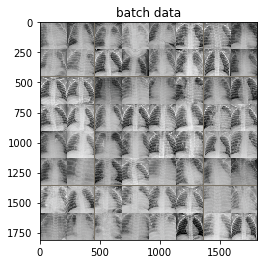

label: ['PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL']


In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))[:4]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#imshow(out, title=[class_names[x] for x in classes])
imshow(out, title="batch data")
print("label: "+str([class_names[x] for x in classes]))

In [20]:
inputs, classes = next(iter(dataloaders[TRAIN]))
inputs.shape

torch.Size([64, 3, 224, 224])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print("="*10)
        
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()
            # initialize the parameters
            # compute the loss
            # compute the gradients
            running_loss = 0.0
            running_corrects = 0
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history when the phase is train
                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc and epoch > 5:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
model_pre = models.resnet18(pretrained=True)

In [12]:
model_pre

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# donot calculate gradient since we will use the weights of pretrained model
for param in model_pre.parameters():
    param.required_grad = False

num_features = model_pre.fc.in_features
# Replace last layer
model_pre.fc = nn.Linear(num_features, len(class_names))

In [14]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [15]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)
time_now = str(datetime.datetime.now())[:-7].replace(" ","-").replace(":","-")
torch.save(model_pre,"../model/"+time_now+".pth")

Epoch: 1/20


C:\Users\Hawee\AppData\Local\Continuum\anaconda3\envs\dlpy36\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1840 Acc: 0.9273
val Loss: 0.8084 Acc: 0.6250
Epoch: 2/20
train Loss: 0.0723 Acc: 0.9745
val Loss: 0.4888 Acc: 0.7500
Epoch: 3/20
train Loss: 0.0487 Acc: 0.9839
val Loss: 0.5889 Acc: 0.6875
Epoch: 4/20
train Loss: 0.0283 Acc: 0.9933
val Loss: 0.2735 Acc: 0.8750
Epoch: 5/20
train Loss: 0.0215 Acc: 0.9946
val Loss: 0.7652 Acc: 0.6250
Epoch: 6/20
train Loss: 0.0160 Acc: 0.9971
val Loss: 0.3614 Acc: 0.8750
Epoch: 7/20
train Loss: 0.0121 Acc: 0.9985
val Loss: 0.3715 Acc: 0.8125
Epoch: 8/20
train Loss: 0.0071 Acc: 0.9998
val Loss: 0.2301 Acc: 0.8750
Epoch: 9/20
train Loss: 0.0085 Acc: 0.9988
val Loss: 0.5364 Acc: 0.8125
Epoch: 10/20
train Loss: 0.0048 Acc: 1.0000
val Loss: 0.4129 Acc: 0.8125
Epoch: 11/20
train Loss: 0.0051 Acc: 1.0000
val Loss: 0.4691 Acc: 0.8125
Epoch: 12/20
train Loss: 0.0050 Acc: 1.0000
val Loss: 0.4207 Acc: 0.8125
Epoch: 13/20
train Loss: 0.0056 Acc: 0.9998
val Loss: 0.4261 Acc: 0.8125
Epoch: 14/20
train Loss: 0.0055 Acc: 0.9996
val Loss: 0.4871 Acc: 0.8125

In [16]:
def test_model(model):
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
        acc = running_correct/running_total
    return (true_labels, pred_labels, running_correct, running_total, acc)

In [17]:
true_labels, pred_labels, running_correct, running_total, acc = test_model(model_pre)
print("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 535.0, Total Test Images: 624.0
Test Accuracy:  0.8573717948717948


**Confusion Matrix, Presision and Recall**

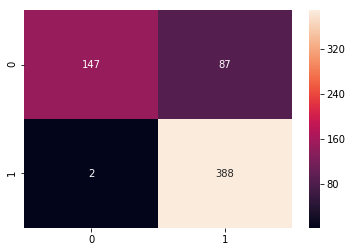

In [18]:
cm = confusion_matrix(true_labels, pred_labels)
# a nice hack for binary classification
tn, fp, fn, tp = cm.ravel()
ax = sns.heatmap(cm, annot=True, fmt="d")

In [19]:
recall = tp/(tp + fn)
precision = tp/((tp + fp))
f1_score = 2 * (recall * precision)/(precision + recall)

In [20]:
print("F1 Score:", f1_score)

F1 Score: 0.8971098265895954
